In [1]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 31.3 MB/s 
     |████████████████████████████████| 596 kB 58.5 MB/s 
     |████████████████████████████████| 6.6 MB 37.4 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 11.4 MB/s 
     |████████████████████████████████| 140 kB 44.1 MB/s 
     |████████████████████████████████| 86 kB 2.8 MB/s 
     |████████████████████████████████| 1.1 MB 50.1 MB/s 
     |████████████████████████████████| 212 kB 51.8 MB/s 
     |████████████████████████████████| 127 kB 38.4 MB/s 
     |████████████████████████████████| 271 kB 52.3 MB/s 
     |█████████████

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
import pandas as pd
import os
import numpy as np
from transformers import AutoConfig, create_optimizer, TFAutoModelForSequenceClassification, AutoModelForSequenceClassification
from transformers import DefaultDataCollator
import tensorflow as tf
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from datasets import load_dataset
import pickle

In [4]:
path = "drive/MyDrive/TE_detection/data/processed_data/"
data_files = {"train": os.path.join(path,"training_set.pkl"), "validation":os.path.join(path,"validation_set.pkl"), "test":os.path.join(path,"test_set.pkl")}
dataset = load_dataset("pandas", data_files=data_files)

with open(os.path.join(path,"tokenize_table.pkl"), 'rb') as f:
    tok = pickle.load(f)

print("number of unique tokens in the data: ", len(tok.keys()))

Using custom data configuration default-d575ce59444cc8b5


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset pandas downloaded and prepared to /root/.cache/huggingface/datasets/pandas/default-d575ce59444cc8b5/0.0.0/6197c1e855b639d75a767140856841a562b7a71d129104973fe1962594877ade. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

number of unique tokens in the data:  32634


In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['origin', 'chunk', 'set', 'tokens', 'token_ids', 'attention_masks', 'labels', '__index_level_0__'],
        num_rows: 209159
    })
    validation: Dataset({
        features: ['origin', 'chunk', 'set', 'tokens', 'token_ids', 'attention_masks', 'labels', '__index_level_0__'],
        num_rows: 12736
    })
    test: Dataset({
        features: ['origin', 'chunk', 'set', 'tokens', 'token_ids', 'attention_masks', 'labels', '__index_level_0__'],
        num_rows: 12668
    })
})

In [6]:
def compute_sequence_label(example):
    return {"sequence_label": 1 if 1 in example["labels"] else 0}

dataset = dataset.map(compute_sequence_label)
dataset = dataset.remove_columns(['origin', 'chunk','set', 'tokens','labels', '__index_level_0__'])
dataset = dataset.rename_column("sequence_label", "labels")
dataset = dataset.rename_column("token_ids", "input_ids")
dataset = dataset.rename_column("attention_masks", "attention_mask")

  0%|          | 0/209159 [00:00<?, ?ex/s]

  0%|          | 0/12736 [00:00<?, ?ex/s]

  0%|          | 0/12668 [00:00<?, ?ex/s]

In [19]:
data_collator = DefaultDataCollator(return_tensors="tf")

tf_train_dataset = dataset["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    #label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_validation_dataset = dataset["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    #label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

tf_test_dataset = dataset["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    #label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

In [ ]:
checkpoint = "FritzOS/train_basic_M_V3"
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
model.summary()

Downloading:   0%|          | 0.00/524 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/357M [00:00<?, ?B/s]

Some layers from the model checkpoint at FritzOS/train_basic_M_V3 were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at FritzOS/train_basic_M_V3 and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictio

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 67714560  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 68,306,690
Trainable params: 68,306,690
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=2)

In [ ]:
model.save_pretrained("drive/MyDrive/TE_detection/model2/")

# Evaluate Model

In [8]:
model_path = "drive/MyDrive/TE_detection/model2"
model = TFAutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at drive/MyDrive/TE_detection/model2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [51]:
def get_predictions(tf_dataset, threshold):
    all_predictions = []
    all_labels = []

    for batch in tf_dataset:
        logits = model.predict(batch)["logits"]
        labels = batch["labels"]
        probs = tf.nn.softmax(logits)
        predictions = [int(prob) for prob in probs[:,1]>threshold]
        labels = [int(label) for label in labels==1]
        for prediction, label in zip(predictions, labels):
                all_predictions.append(prediction)
                all_labels.append(label)
    return all_predictions, all_labels

def compute_metrics(pred, labels):

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)
    cm = confusion_matrix(all_labels, all_predictions)
    cm_n = confusion_matrix(all_labels, all_predictions, normalize="true")

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "cm":cm, "cm_normalized":cm_n}

In [54]:
print(f'TEs in the data: {sum(dataset["test"]["labels"])/len(dataset["test"]["labels"])*100:.2f}%')

TEs in the data: 19.81%


Using threshold 0.5...

TEs in the data: 19.81%
Accuracy: 96.67


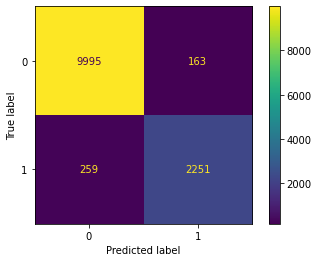

Accuracy:   96.67%
precision:  93.25%
recall:     89.68%
f1:         91.43%

Confusion matrix:
[[9995  163]
 [ 259 2251]]


In [52]:
# Threshold: 0.5
threshold = 0.5
print(f"Using threshold {threshold}...\n")
all_predictions, all_labels = get_predictions(tf_test_dataset, threshold)
metrics = compute_metrics(all_predictions, all_labels)

disp = ConfusionMatrixDisplay(metrics["cm"])
disp.plot()
plt.show()

print(f'Accuracy:   {metrics["accuracy"]*100:.2f}%')
print(f'precision:  {metrics["precision"]*100:.2f}%')
print(f'recall:     {metrics["recall"]*100:.2f}%')
print(f'f1:         {metrics["f1"]*100:.2f}%')
print(f'\nConfusion matrix:\n{metrics["cm"]}')

Using threshold 0.1...

TEs in the data: 19.81%
Accuracy: 96.61


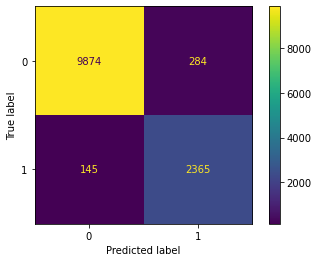

Accuracy:   96.61%
precision:  89.28%
recall:     94.22%
f1:         91.68%

Confusion matrix:
[[9874  284]
 [ 145 2365]]


In [53]:
# Threshold: 0.1
threshold = 0.1
print(f"Using threshold {threshold}...\n")

all_predictions, all_labels = get_predictions(tf_test_dataset, threshold)
metrics = compute_metrics(all_predictions, all_labels)

disp = ConfusionMatrixDisplay(metrics["cm"])
disp.plot()
plt.show()

print(f'Accuracy:   {metrics["accuracy"]*100:.2f}%')
print(f'precision:  {metrics["precision"]*100:.2f}%')
print(f'recall:     {metrics["recall"]*100:.2f}%')
print(f'f1:         {metrics["f1"]*100:.2f}%')
print(f'\nConfusion matrix:\n{metrics["cm"]}')